In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

In [2]:
# Verifica se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device: ", device)

 Device:  cuda


In [3]:
# Dados de exemplo
input_size = 784  # Número de features (pixels em uma imagem MNIST de 28x28)
hidden_size = 128  # Número de neurônios na camada oculta
output_size = 10  # Número de classes (para o conjunto de dados MNIST)
batch_size = 64  # Tamanho do lote
learning_rate = 0.001  # Taxa de aprendizado

In [4]:
# Criação do modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Carrega dados MNIST (como exemplo)
# Suponha que você tenha dados de treino em X_train e rótulos correspondentes em y_train
# X_train e y_train devem ser tensores torch
# Para este exemplo, vamos criar tensores aleatórios
X_train = torch.rand((1000, input_size)).to(device)
y_train = torch.randint(0, output_size, (1000,)).to(device)

# Cria DataLoader para facilitar o treinamento em lotes
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Divide os dados em conjuntos de treinamento, validação e teste
total_samples = len(train_dataset)
train_size = int(0.8 * total_samples)
valid_size = int(0.1 * total_samples)
test_size = total_samples - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [7]:
# Modelo, critério e otimizador
model = MLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Listas para armazenar as perdas de treinamento, validação e precisões
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Loop de treinamento e validação
num_epochs = 10

for epoch in range(num_epochs):
    # Treinamento
    model.train()
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.view(-1, input_size).to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

    average_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)

    # Validação
    model.eval()
    valid_loss = 0.0
    correct_valid_predictions = 0
    total_valid_samples = 0
    
    with torch.no_grad():
        for data, targets in valid_loader:
            data = data.view(-1, input_size).to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid_predictions += (predicted == targets).sum().item()
            total_valid_samples += targets.size(0)

    average_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = correct_valid_predictions / total_valid_samples
    valid_losses.append(average_valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Época {epoch+1}/{num_epochs}, Perda de Treinamento: {average_train_loss:.4f}, Precisão de Treinamento: {train_accuracy:.4f}, Perda de Validação: {average_valid_loss:.4f}, Precisão de Validação: {valid_accuracy:.4f}')


Época 1/10, Perda de Treinamento: 2.3254, Precisão de Treinamento: 0.0988, Perda de Validação: 2.3382, Precisão de Validação: 0.1000
Época 2/10, Perda de Treinamento: 2.2897, Precisão de Treinamento: 0.1200, Perda de Validação: 2.3503, Precisão de Validação: 0.0800
Época 3/10, Perda de Treinamento: 2.2724, Precisão de Treinamento: 0.1525, Perda de Validação: 2.3260, Precisão de Validação: 0.1500
Época 4/10, Perda de Treinamento: 2.2698, Precisão de Treinamento: 0.1350, Perda de Validação: 2.3416, Precisão de Validação: 0.0600
Época 5/10, Perda de Treinamento: 2.2506, Precisão de Treinamento: 0.2300, Perda de Validação: 2.3569, Precisão de Validação: 0.0800
Época 6/10, Perda de Treinamento: 2.2292, Precisão de Treinamento: 0.1825, Perda de Validação: 2.3139, Precisão de Validação: 0.0500
Época 7/10, Perda de Treinamento: 2.2028, Precisão de Treinamento: 0.2387, Perda de Validação: 2.3523, Precisão de Validação: 0.0400
Época 8/10, Perda de Treinamento: 2.1795, Precisão de Treinamento: 0.

In [9]:
# Teste do modelo
model.eval()
test_loss = 0.0
correct_test_predictions = 0
total_test_samples = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.view(-1, input_size).to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test_predictions += (predicted == targets).sum().item()
        total_test_samples += targets.size(0)

average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_test_predictions / total_test_samples

print(f'Perda de Teste: {average_test_loss:.4f}, Precisão de Teste: {test_accuracy:.4f}')

Perda de Teste: 2.3272, Precisão de Teste: 0.0900


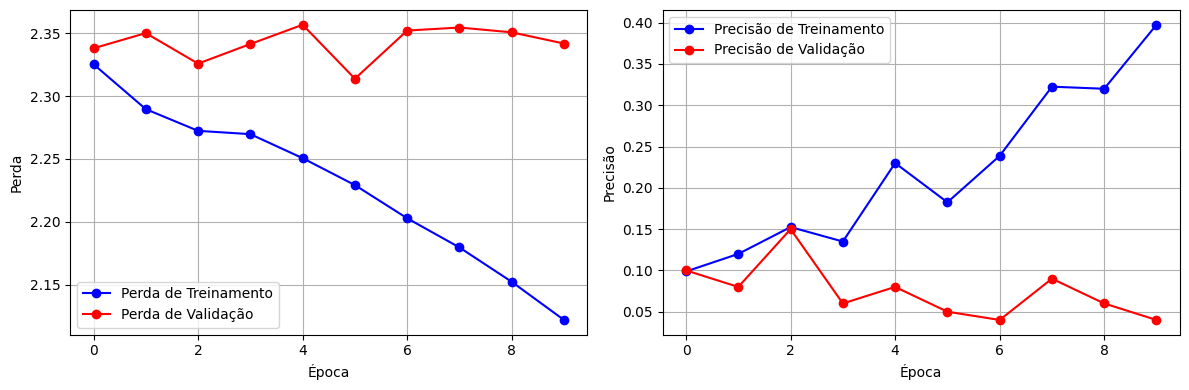

In [10]:
# Plota gráficos de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='b', label='Perda de Treinamento')
plt.plot(valid_losses, marker='o', color='r', label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='b', label='Precisão de Treinamento')
plt.plot(valid_accuracies, marker='o', color='r', label='Precisão de Validação')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Função para avaliar o modelo
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(-1, input_size).to(device)
            output = model(data)
            _, prediction = torch.max(output, 1)
            
            predictions.extend(prediction.cpu().tolist())
            targets.extend(target.cpu().tolist())

    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')  # 'weighted' para multiclasse
    recall = recall_score(targets, predictions, average='weighted')  # 'weighted' para multiclasse
    f1 = f1_score(targets, predictions, average='weighted')  # 'weighted' para multiclasse
    cm = confusion_matrix(targets, predictions)

    return accuracy, precision, recall, f1, cm

# Avalia o modelo usando o conjunto de teste
accuracy, precision, recall, f1, confusion_matrix = evaluate_model(model, test_loader)
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Matriz de Confusão:\n{confusion_matrix}')

Acurácia: 0.0900
Precisão: 0.0490
Recall: 0.0900
F1-Score: 0.0596
Matriz de Confusão:
[[0 1 4 0 1 1 0 0 1 0]
 [0 2 1 0 3 1 0 0 0 0]
 [0 4 1 0 0 2 0 0 0 0]
 [0 6 4 0 0 4 0 0 0 0]
 [0 3 5 0 1 2 0 0 0 0]
 [0 4 3 0 2 5 0 1 0 0]
 [0 2 5 0 0 1 0 0 1 0]
 [0 2 3 0 1 4 0 0 1 0]
 [0 4 2 0 1 2 0 0 0 0]
 [0 3 3 0 0 3 0 0 0 0]]


/home/helvecioneto/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Função para fazer previsões usando o modelo
def predict(model, dataloader):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(-1, input_size).to(device)
            output = model(data)
            _, prediction = torch.max(output, 1)
            
            predictions.extend(prediction.cpu().tolist())  # Mova o tensor para a CPU antes de converter para uma lista
            targets.extend(target.cpu().tolist())  # Mova o tensor para a CPU antes de converter para uma lista

    return predictions, targets

# Função para comparar observado e previsto e plotar os resultados com cores diferentes para cada classe
def plot_results(observed, predicted, class_names):
    num_classes = len(class_names)
    colors = plt.cm.get_cmap('tab10', num_classes)  # Mapa de cores para num_classes classes
    markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '+', 'x']  # Marcadores diferentes para cada classe
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        observed_class = np.array([observed[j] for j in range(len(observed)) if observed[j] == i])
        predicted_class = np.array([predicted[j] for j in range(len(predicted)) if observed[j] == i])
        plt.scatter(observed_class, predicted_class, color=colors(i), label=f'Classe {class_names[i]}', marker=markers[i], alpha=0.7)

    plt.xlabel('Observado')
    plt.ylabel('Previsto')
    plt.legend()
    plt.grid(True)
    plt.title('Comparação entre Observado e Previsto')
    plt.show()

/tmp/ipykernel_5895/781073937.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)  # Mapa de cores para num_classes classes


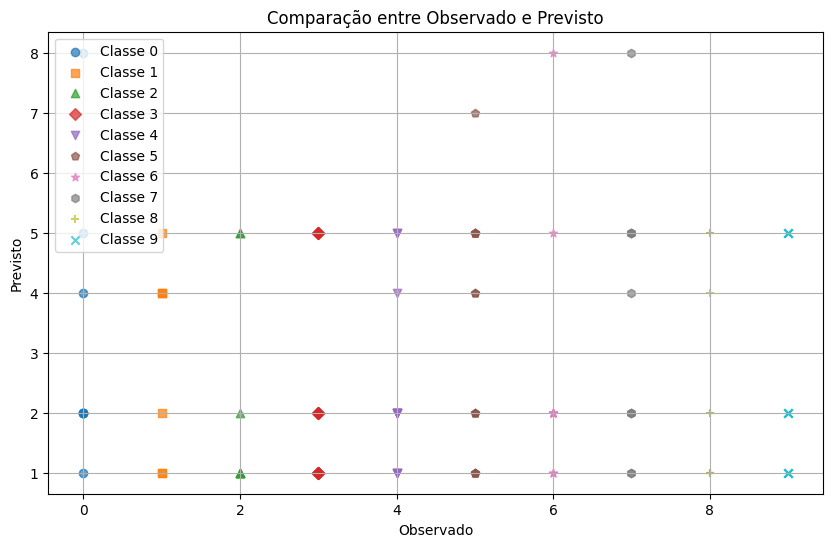

In [43]:
# Faz previsões usando o conjunto de teste
predictions, targets = predict(model, test_loader)

# Classes no conjunto de teste (substitua pelos nomes das suas classes)
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Exemplo para MNIST

# Plota os resultados com cores e marcadores diferentes para cada classe
plot_results(targets, predictions, class_names)